# Capstone Project: Saudi Arabia Historical Climate Data - Machine Learning
# Forecasting Using Sliding Window Approach
**SDA Data Science Bootcamp** <br>
**By Yasmeen Aldossary, Nourah Al-Mutlaq, Halah Almodarra and Abdullah Alhussain**<br>
**15 July 2021**

In [1]:
# Importing required libraries
import sklearn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score, accuracy_score, recall_score, precision_score
import warnings
plt.style.use("seaborn-whitegrid")
warnings.filterwarnings('ignore')

In [2]:
# Load Dataset
df = pd.read_csv("https://raw.githubusercontent.com/Yasmeenmad/data_science_bootcamp/main/Capstone_Project/Datasets/saudi_arabia_weather_history.csv")
# Display the top 5 rows
condition1 = df['city'] != 'Assir'
condition2 = df['city'] != 'Riyadh'
condition3 = df['city'] != 'EP'

df.head()

,Unnamed: 0,city,date,time,year,month,day,hour,minute,weather,temp,wind,humidity,barometer,visibility
0,0,Qassim,1 January 2017,00:00,2017,1,1,24,0,Clear,17,11,64%,1018.0,16
1,1,Qassim,1 January 2017,01:00,2017,1,1,1,0,Clear,17,6,64%,1018.0,16
2,2,Qassim,1 January 2017,03:00,2017,1,1,3,0,Clear,15,11,72%,1019.0,16
3,3,Qassim,1 January 2017,04:00,2017,1,1,4,0,Clear,15,11,72%,1019.0,16
4,4,Qassim,1 January 2017,05:00,2017,1,1,5,0,Clear,15,9,72%,1019.0,16


**In the following step, we are removing three cities from the dataset which are Assir, Riyadh and EP because they consist of many missing values.**

In [3]:
#Filtering Assir, Riyadh and Eastern Province
df_filtered_0 = df[condition1]
df_filtered_1 = df_filtered_0[condition2]
df_filtered = df_filtered_1[condition3]
df_filtered['city'].value_counts()

Jawf                20352
Mecca               20268
Tabuk               20240
Northern boarder    20235
Hail                20121
Madina              19965
Baha                19959
Najran              19847
Jazan               19829
Qassim              19793
Name: city, dtype: int64

**Encoding the cities using one hot encoding**

In [4]:
#One hot encoding for the cities
from tensorflow.keras.utils import to_categorical
df_filtered['city'] = df_filtered['city'].replace(['Jawf'],'0')
df_filtered['city'] = df_filtered['city'].replace(['Mecca'],'1')
df_filtered['city'] = df_filtered['city'].replace(['Tabuk'],'2')
df_filtered['city'] = df_filtered['city'].replace(['Northern boarder'],'3')
df_filtered['city'] = df_filtered['city'].replace(['Hail'],'4')
df_filtered['city'] = df_filtered['city'].replace(['Madina'],'5')
df_filtered['city'] = df_filtered['city'].replace(['Baha'],'6')
df_filtered['city'] = df_filtered['city'].replace(['Najran'],'7')
df_filtered['city'] = df_filtered['city'].replace(['Jazan'],'8')
df_filtered['city'] = df_filtered['city'].replace(['Qassim'],'9')




cities_encoded = to_categorical(df_filtered['city'])
cities_encoded

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [5]:
df_filtered

,Unnamed: 0,city,date,time,year,month,day,hour,minute,weather,temp,wind,humidity,barometer,visibility
0,0,9,1 January 2017,00:00,2017,1,1,24,0,Clear,17,11,64%,1018.0,16
1,1,9,1 January 2017,01:00,2017,1,1,1,0,Clear,17,6,64%,1018.0,16
2,2,9,1 January 2017,03:00,2017,1,1,3,0,Clear,15,11,72%,1019.0,16
3,3,9,1 January 2017,04:00,2017,1,1,4,0,Clear,15,11,72%,1019.0,16
4,4,9,1 January 2017,05:00,2017,1,1,5,0,Clear,15,9,72%,1019.0,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249018,2848,0,30 April 2019,19:00,2019,4,30,19,0,Passing clouds,32,19,14%,1014.0,-1
249019,2849,0,30 April 2019,20:00,2019,4,30,20,0,Passing clouds,29,9,22%,1015.0,-1
249020,2850,0,30 April 2019,21:00,2019,4,30,21,0,Passing clouds,27,7,24%,1016.0,-1
249021,2851,0,30 April 2019,22:00,2019,4,30,22,0,Clear,26,0,26%,1017.0,16


In [6]:
Wind_Temp = df_filtered[['temp','wind']]
Wind_Temp

,temp,wind
0,17,11
1,17,6
2,15,11
3,15,11
4,15,9
...,...,...
249018,32,19
249019,29,9
249020,27,7
249021,26,0


In [7]:
scaler_wind_temp = StandardScaler()
Wind_Temp_scaled = scaler_wind_temp.fit_transform(Wind_Temp)
Wind_Temp_scaled

array([[-0.84878198, -0.23187158],
       [-0.84878198, -0.80530054],
       [-1.07427907, -0.23187158],
       ...,
       [ 0.27870347, -0.69061475],
       [ 0.16595493, -1.4934153 ],
       [-0.05954216, -0.69061475]])

In [8]:
scaler_wind_temp = StandardScaler()
Wind_Temp_scaled = scaler_wind_temp.fit_transform(Wind_Temp)
Wind_Temp_scaled = pd.DataFrame(Wind_Temp_scaled)
Wind_Temp_scaled.rename(columns = {0:'temp', 1:'wind'}, inplace = True)

Wind_Temp_scaled

,temp,wind
0,-0.848782,-0.231872
1,-0.848782,-0.805301
2,-1.074279,-0.231872
3,-1.074279,-0.231872
4,-1.074279,-0.461243
...,...,...
200604,0.842446,0.685615
200605,0.504201,-0.461243
200606,0.278703,-0.690615
200607,0.165955,-1.493415


In [9]:
df_cities_enc = pd.DataFrame.from_records(cities_encoded)

In [10]:
df_cities_enc['temp'] = Wind_Temp_scaled['temp']
df_cities_enc['wind'] = Wind_Temp_scaled['wind']
df_cities_enc

,0,1,2,3,4,5,6,7,8,9,temp,wind
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.848782,-0.231872
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.848782,-0.805301
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.074279,-0.231872
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.074279,-0.231872
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.074279,-0.461243
...,...,...,...,...,...,...,...,...,...,...,...,...
200604,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.842446,0.685615
200605,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.504201,-0.461243
200606,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.278703,-0.690615
200607,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.165955,-1.493415


In [135]:
data_set = df_cities_enc.copy()

**Using a sliding window technique to introduce lagged columns of Wind Speed and Temperature Data**

In [136]:
data_set["wind(t-1)"] = data_set["wind"].shift(1)
data_set["wind(t-2)"] = data_set["wind"].shift(2)
data_set["wind(t-3)"] = data_set["wind"].shift(3)
data_set["temp(t-1)"] = data_set["temp"].shift(1)
data_set["temp(t-2)"] = data_set["temp"].shift(2)
data_set["temp(t-3)"] = data_set["temp"].shift(3)
data_set = data_set.fillna(method='ffill').fillna(method='bfill')
data_set  

,0,1,2,3,4,5,6,7,8,9,temp,wind,wind(t-1),wind(t-2),wind(t-3),temp(t-1),temp(t-2),temp(t-3)
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.848782,-0.231872,-0.231872,-0.231872,-0.231872,-0.848782,-0.848782,-0.848782
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.848782,-0.805301,-0.231872,-0.231872,-0.231872,-0.848782,-0.848782,-0.848782
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.074279,-0.231872,-0.805301,-0.231872,-0.231872,-0.848782,-0.848782,-0.848782
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.074279,-0.231872,-0.231872,-0.805301,-0.231872,-1.074279,-0.848782,-0.848782
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.074279,-0.461243,-0.231872,-0.231872,-0.805301,-1.074279,-1.074279,-0.848782
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200604,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.842446,0.685615,0.456243,0.685615,0.226872,1.067943,1.180692,1.180692
200605,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.504201,-0.461243,0.685615,0.456243,0.685615,0.842446,1.067943,1.180692
200606,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.278703,-0.690615,-0.461243,0.685615,0.456243,0.504201,0.842446,1.067943
200607,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.165955,-1.493415,-0.690615,-0.461243,0.685615,0.278703,0.504201,0.842446


**Defining Input and Output Columns**

In [13]:
Y = data_set[['temp','wind']].values
X = data_set.drop(columns=['temp','wind']).values

**Train-Test Split**

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=42)

In [15]:
n_features = data_set.drop(columns=['temp','wind']).shape[1]
n_features

16

**Training three different machine learning algorithms which are Random Forest, Support Vector Regression and K-Nearest-Neighbor on the data set with different Number of Lags and Step Sizes.**

In [21]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

i = 3 #Time Lag
j = 1 #Step Size
RanFor_Temp_MSE = []
RanFor_Temp_MAE = []
RanFor_Wind_MSE = []
RanFor_Wind_MAE = []
KNN_Temp_MSE = []
KNN_Temp_MAE = []
KNN_Wind_MSE = []
KNN_Wind_MAE = []
SVM_Temp_MSE = []
SVM_Temp_MAE = []
SVM_Wind_MSE = []
SVM_Wind_MAE = []
Number_Lags = []
Step_Size = []

while (j<=4):
    i = 3
    while (i<=7):
        data_set = df_cities_enc.copy()
        n = 1
        while (n<=i):
            data_set[str(n)] = data_set["wind"].shift(j*n)
            data_set[str(300*n)] = data_set["temp"].shift(j*n)
            n = n+1
        data_set = data_set.fillna(method='ffill').fillna(method='bfill')
        Y = data_set[['temp','wind']].values
        X = data_set.drop(columns=['temp','wind']).values
        X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=42)
        regr = RandomForestRegressor(max_depth=4, random_state=0)
        regr.fit(X_train, y_train[:,0])
        RanFor_Temp_MAE.append(mean_absolute_error(y_true=y_test[:,0], y_pred=regr.predict(X_test)))
        RanFor_Temp_MSE.append(mean_squared_error(y_true=y_test[:,0], y_pred=regr.predict(X_test)))
        regr = RandomForestRegressor(max_depth=4, random_state=0)
        regr.fit(X_train, y_train[:,1])
        RanFor_Wind_MAE.append(mean_absolute_error(y_true=y_test[:,1], y_pred=regr.predict(X_test)))
        RanFor_Wind_MSE.append(mean_squared_error(y_true=y_test[:,1], y_pred=regr.predict(X_test)))
        neigh = KNeighborsRegressor(n_neighbors=2)
        neigh.fit(X_train, y_train[:,0])
        KNN_Temp_MAE.append(mean_absolute_error(y_true=y_test[:,0], y_pred=neigh.predict(X_test)))
        KNN_Temp_MSE.append(mean_squared_error(y_true=y_test[:,0], y_pred=neigh.predict(X_test)))
        neigh = KNeighborsRegressor(n_neighbors=2)
        neigh.fit(X_train, y_train[:,1])
        KNN_Wind_MAE.append(mean_absolute_error(y_true=y_test[:,1], y_pred=neigh.predict(X_test)))
        KNN_Wind_MSE.append(mean_squared_error(y_true=y_test[:,1], y_pred=neigh.predict(X_test)))
        SVRreg = SVR(C=1.0, epsilon=0.2)
        SVRreg.fit(X_train, y_train[:,0])
        SVM_Temp_MAE.append(mean_absolute_error(y_true=y_test[:,0], y_pred=SVRreg.predict(X_test)))
        SVM_Temp_MSE.append(mean_squared_error(y_true=y_test[:,0], y_pred=SVRreg.predict(X_test)))
        SVRreg = SVR(C=1.0, epsilon=0.2)
        SVRreg.fit(X_train, y_train[:,1])
        SVM_Wind_MAE.append(mean_absolute_error(y_true=y_test[:,1], y_pred=SVRreg.predict(X_test)))
        SVM_Wind_MSE.append(mean_squared_error(y_true=y_test[:,1], y_pred=SVRreg.predict(X_test)))
        Number_Lags.append(i)
        Step_Size.append(j)

        i = i + 1
    j=j+1

KNN_Wind_MSE

[0.5100410552664537,
 0.5061199345847924,
 0.4997781842170591,
 0.4989115349736393,
 0.4971911307763877,
 0.6869337710014508,
 0.6835591824331375,
 0.6662891391817134,
 0.6503863823580146,
 0.6272377450644446,
 0.8000649350017572,
 0.7788256360299973,
 0.7521542897483114,
 0.7094902544367316,
 0.6685181029022125,
 0.8857200616311653,
 0.8351732990724289,
 0.7851982015643734,
 0.7302457990016551,
 0.6931435188113666]

In [22]:
j

5

**Results of The Machine Learning Models**

In [23]:
dict = {'RanFor_Temp_MSE': RanFor_Temp_MSE, 'RanFor_Temp_MAE': RanFor_Temp_MAE, 'RanFor_Wind_MSE': RanFor_Wind_MSE, 'RanFor_Wind_MAE': RanFor_Wind_MAE,
        'KNN_Temp_MSE': KNN_Temp_MSE, 'KNN_Temp_MAE': KNN_Temp_MAE, 'KNN_Wind_MSE': KNN_Wind_MSE, 'KNN_Wind_MAE':KNN_Wind_MAE,
        'SVM_Temp_MSE': SVM_Temp_MSE, 'SVM_Temp_MAE': SVM_Temp_MAE, 'SVM_Wind_MSE': SVM_Wind_MSE, 'SVM_Wind_MAE':SVM_Wind_MAE,        
        'Number_Lags': Number_Lags, 'Step_Size':Step_Size} 
    
result_df = pd.DataFrame(dict)
result_df

,RanFor_Temp_MSE,RanFor_Temp_MAE,RanFor_Wind_MSE,RanFor_Wind_MAE,KNN_Temp_MSE,KNN_Temp_MAE,KNN_Wind_MSE,KNN_Wind_MAE,SVM_Temp_MSE,SVM_Temp_MAE,SVM_Wind_MSE,SVM_Wind_MAE,Number_Lags,Step_Size
0,0.033962,0.143211,0.379827,0.458817,0.038618,0.145209,0.510041,0.530440,0.018590,0.100459,0.348284,0.435142,3,1
1,0.033962,0.143211,0.379827,0.458817,0.044951,0.157109,0.506120,0.527798,0.018250,0.099505,0.344835,0.433180,4,1
2,0.033962,0.143211,0.379822,0.458811,0.052103,0.169699,0.499778,0.526840,0.018002,0.098704,0.342459,0.431814,5,1
3,0.033962,0.143211,0.379822,0.458811,0.057326,0.177979,0.498912,0.526724,0.017751,0.097919,0.340866,0.430910,6,1
4,0.033962,0.143211,0.379822,0.458811,0.061715,0.184279,0.497191,0.526650,0.017466,0.097097,0.339953,0.430463,7,1
5,0.080511,0.220387,0.553451,0.568410,0.085561,0.213275,0.686934,0.627124,0.045976,0.155929,0.484304,0.522915,3,2
6,0.080511,0.220387,0.552896,0.568172,0.091535,0.220426,0.683559,0.623059,0.042261,0.149532,0.478308,0.519718,4,2
7,0.080511,0.220387,0.552222,0.567849,0.095592,0.224987,0.666289,0.615968,0.038931,0.143374,0.472743,0.516418,5,2
8,0.080511,0.220387,0.552219,0.567849,0.092854,0.221122,0.650386,0.608707,0.036244,0.138411,0.469565,0.514594,6,2
9,0.080096,0.220690,0.552219,0.567849,0.087134,0.213224,0.627238,0.595924,0.033163,0.132408,0.465529,0.512348,7,2


**Plotting the results of the machine learning models**

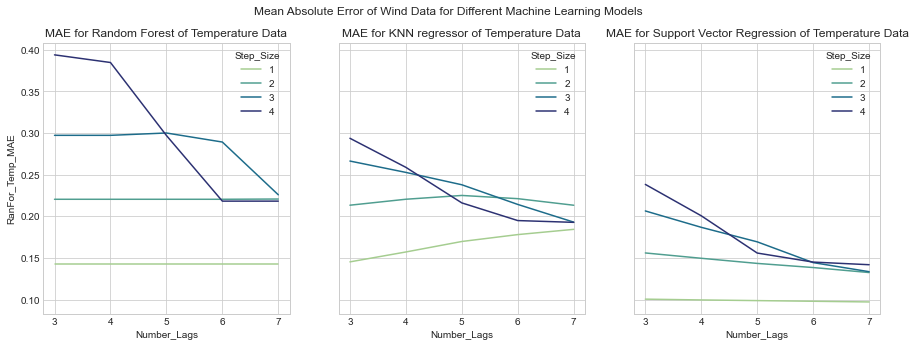

In [64]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
fig.suptitle('Mean Absolute Error of Wind Data for Different Machine Learning Models')

# Bulbasaur
sns.lineplot(ax=axes[0], data=result_df, x="Number_Lags", y="RanFor_Temp_MAE", hue="Step_Size", palette='crest')
axes[0].set_title('MAE for Random Forest of Temperature Data')

# Charmander
sns.lineplot(ax=axes[1], data=result_df, x="Number_Lags", y="KNN_Temp_MAE", hue="Step_Size", palette='crest')
axes[1].set_title('MAE for KNN regressor of Temperature Data')

# Squirtle
sns.lineplot(ax=axes[2], data=result_df, x="Number_Lags", y="SVM_Temp_MAE", hue="Step_Size", palette='crest')
axes[2].set_title('MAE for Support Vector Regression of Temperature Data')

plt.savefig('MAE_Wind.png')

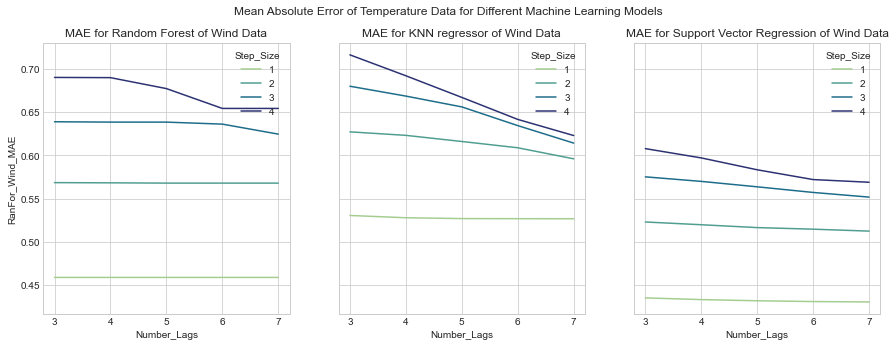

In [65]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
fig.suptitle('Mean Absolute Error of Temperature Data for Different Machine Learning Models')

# Bulbasaur
sns.lineplot(ax=axes[0], data=result_df, x="Number_Lags", y="RanFor_Wind_MAE", hue="Step_Size", palette='crest')
axes[0].set_title('MAE for Random Forest of Wind Data')

# Charmander
sns.lineplot(ax=axes[1], data=result_df, x="Number_Lags", y="KNN_Wind_MAE", hue="Step_Size", palette='crest')
axes[1].set_title('MAE for KNN regressor of Wind Data')

# Squirtle
sns.lineplot(ax=axes[2], data=result_df, x="Number_Lags", y="SVM_Wind_MAE", hue="Step_Size", palette='crest')
axes[2].set_title('MAE for Support Vector Regression of Wind Data')

plt.savefig('MAE_Temperature.png')

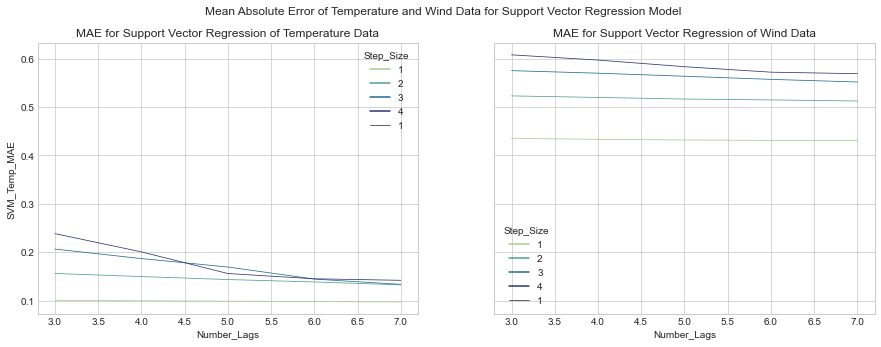

In [66]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
fig.suptitle('Mean Absolute Error of Temperature and Wind Data for Support Vector Regression Model')

# Bulbasaur
sns.lineplot(ax=axes[0], data=result_df, x="Number_Lags", y="SVM_Temp_MAE", hue="Step_Size", size=1, palette='crest')
axes[0].set_title('MAE for Support Vector Regression of Temperature Data')
#axes[0].set_xticklabels(step=1)

# Squirtle
sns.lineplot(ax=axes[1], data=result_df, x="Number_Lags", y="SVM_Wind_MAE", hue="Step_Size", size=1, palette='crest')
axes[1].set_title('MAE for Support Vector Regression of Wind Data')
#axes.set_xticklabels(step=1)
#axes.set(xlabel='Number of Lags', ylabel='Mean Absolute Error')

plt.savefig('MAE_SVR.png')

**Now, the aim of this experiment is to compare the accuracy of using step size of 1 with step size of 4 for the three machine learning models used above.**

In [97]:
data_set_lag1 = df_cities_enc.copy()
data_set_lag4 = df_cities_enc.copy()

In [98]:
data_set_lag1["wind(t-1)"] = data_set_lag1["wind"].shift(1)
data_set_lag1["wind(t-2)"] = data_set_lag1["wind"].shift(2)
data_set_lag1["wind(t-3)"] = data_set_lag1["wind"].shift(3)
data_set_lag1["wind(t-4)"] = data_set_lag1["wind"].shift(4)

data_set_lag1["temp(t-1)"] = data_set_lag1["temp"].shift(1)
data_set_lag1["temp(t-2)"] = data_set_lag1["temp"].shift(2)
data_set_lag1["temp(t-3)"] = data_set_lag1["temp"].shift(3)
data_set_lag1["temp(t-4)"] = data_set_lag1["temp"].shift(4)

data_set_lag1 = data_set_lag1.fillna(method='ffill').fillna(method='bfill')

data_set_lag4["wind(t-4)"] = data_set_lag4["wind"].shift(4)
data_set_lag4["wind(t-8)"] = data_set_lag4["wind"].shift(8)
data_set_lag4["wind(t-12)"] = data_set_lag4["wind"].shift(12)
data_set_lag4["wind(t-16)"] = data_set_lag4["wind"].shift(16)

data_set_lag4["temp(t-4)"] = data_set_lag4["temp"].shift(4)
data_set_lag4["temp(t-8)"] = data_set_lag4["temp"].shift(8)
data_set_lag4["temp(t-12)"] = data_set_lag4["temp"].shift(12)
data_set_lag4["temp(t-16)"] = data_set_lag4["temp"].shift(16)

data_set_lag4 = data_set_lag4.fillna(method='ffill').fillna(method='bfill')

In [99]:
Y_lag1 = data_set_lag1[['temp','wind']].values
X_lag1 = data_set_lag1.drop(columns=['temp','wind']).values
Y_lag4 = data_set_lag4[['temp','wind']].values
X_lag4 = data_set_lag4.drop(columns=['temp','wind']).values

In [100]:
X_train_lag1, X_test_lag1, y_train_lag1, y_test_lag1 = train_test_split(X_lag1, Y_lag1, test_size=0.30, random_state=42)
X_train_lag4, X_test_lag4, y_train_lag4, y_test_lag4 = train_test_split(X_lag4, Y_lag4, test_size=0.30, random_state=42)

In [105]:
from sklearn.ensemble import RandomForestRegressor
regr_temp_lag1 = RandomForestRegressor(max_depth=4, random_state=0)
regr_temp_lag1.fit(X_train_lag1, y_train_lag1[:,0])
regr_wind_lag1 = RandomForestRegressor(max_depth=4, random_state=0)
regr_wind_lag1.fit(X_train_lag1, y_train_lag1[:,1])

regr_temp_lag4 = RandomForestRegressor(max_depth=4, random_state=0)
regr_temp_lag4.fit(X_train_lag4, y_train_lag4[:,0])
regr_wind_lag4 = RandomForestRegressor(max_depth=4, random_state=0)
regr_wind_lag4.fit(X_train_lag4, y_train_lag4[:,1])

RandomForestRegressor(max_depth=4, random_state=0)

In [127]:
i = 500

temp_best = []
wind_best = []

while(i<10500):
    temp_lag1 = regr_temp_lag1.predict(X_lag1[i-3,:].reshape(1, -1))[0]
    wind_lag1 = regr_wind_lag1.predict(X_lag1[i-3,:].reshape(1, -1))[0]
    temp_lag4 = regr_temp_lag4.predict(X_lag4[i,:].reshape(1, -1))[0]
    wind_lag4 = regr_wind_lag4.predict(X_lag4[i,:].reshape(1, -1))[0]

    my_in_list = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]
    my_in_list.append(wind_lag1)
    my_in_list.append(X_lag1[i-3,10])
    my_in_list.append(X_lag1[i-3,11])
    my_in_list.append(X_lag1[i-3,12])
    my_in_list.append(temp_lag1)
    my_in_list.append(X_lag1[i-3,14])
    my_in_list.append(X_lag1[i-3,15])
    my_in_list.append(X_lag1[i-3,16])

    my_in_list = np.asarray(my_in_list)

    temp_lag1 = regr_temp_lag1.predict(my_in_list.reshape(1, -1))[0]
    wind_lag1 = regr_wind_lag1.predict(my_in_list.reshape(1, -1))[0]

    my_in_list_01 = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]
    my_in_list_01.append(wind_lag1)
    my_in_list_01.append(my_in_list[10])
    my_in_list_01.append(my_in_list[11])
    my_in_list_01.append(my_in_list[12])
    my_in_list_01.append(temp_lag1)
    my_in_list_01.append(my_in_list[14])
    my_in_list_01.append(my_in_list[15])
    my_in_list_01.append(my_in_list[16])

    my_in_list_01 = np.asarray(my_in_list_01)

    temp_lag1 = regr_temp_lag1.predict(my_in_list_01.reshape(1, -1))[0]
    wind_lag1 = regr_wind_lag1.predict(my_in_list_01.reshape(1, -1))[0]

    my_in_list_02 = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]
    my_in_list_02.append(wind_lag1)
    my_in_list_02.append(my_in_list[10])
    my_in_list_02.append(my_in_list[11])
    my_in_list_02.append(my_in_list[12])
    my_in_list_02.append(temp_lag1)
    my_in_list_02.append(my_in_list[14])
    my_in_list_02.append(my_in_list[15])
    my_in_list_02.append(my_in_list[16])

    my_in_list_02 = np.asarray(my_in_list_02)


    temp_lag1 = regr_temp_lag1.predict(my_in_list_02.reshape(1, -1))[0]
    wind_lag1 = regr_wind_lag1.predict(my_in_list_02.reshape(1, -1))[0]


    temp_lag1_perc_error = abs((Y_lag1[i,0] - temp_lag1)/Y_lag1[i,0])
    temp_lag4_perc_error = abs((Y_lag4[i,0] - temp_lag4)/Y_lag4[i,0])

    wind_lag1_perc_error = abs((Y_lag1[i,1] - wind_lag1)/Y_lag1[i,1])
    wind_lag4_perc_error = abs((Y_lag4[i,1] - wind_lag4)/Y_lag4[i,1])

    if(temp_lag1_perc_error < temp_lag4_perc_error):
        temp_best.append(1)
    if(temp_lag4_perc_error < temp_lag1_perc_error):
        temp_best.append(4)
    if(wind_lag1_perc_error < wind_lag4_perc_error):
        wind_best.append(1)
    if(wind_lag4_perc_error < wind_lag1_perc_error):
        wind_best.append(4)
    i = i + 1


In [128]:
print(temp_best.count(1))
print(temp_best.count(4))
print(wind_best.count(1))
print(wind_best.count(4))

4129
5871
5035
4965


In [129]:
regr_temp_lag1 = SVR(C=1.0, epsilon=0.2)
regr_temp_lag1.fit(X_train_lag1, y_train_lag1[:,0])
regr_wind_lag1 = SVR(C=1.0, epsilon=0.2)
regr_wind_lag1.fit(X_train_lag1, y_train_lag1[:,1])

regr_temp_lag4 = SVR(C=1.0, epsilon=0.2)
regr_temp_lag4.fit(X_train_lag4, y_train_lag4[:,0])
regr_wind_lag4 = SVR(C=1.0, epsilon=0.2)
regr_wind_lag4.fit(X_train_lag4, y_train_lag4[:,1])

#SVR(C=1.0, epsilon=0.2)

SVR(epsilon=0.2)

In [130]:

i = 500

temp_best_SVM = []
wind_best_SVM = []

while(i<10500):
    temp_lag1 = regr_temp_lag1.predict(X_lag1[i-3,:].reshape(1, -1))[0]
    wind_lag1 = regr_wind_lag1.predict(X_lag1[i-3,:].reshape(1, -1))[0]
    temp_lag4 = regr_temp_lag4.predict(X_lag4[i,:].reshape(1, -1))[0]
    wind_lag4 = regr_wind_lag4.predict(X_lag4[i,:].reshape(1, -1))[0]

    my_in_list = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]
    my_in_list.append(wind_lag1)
    my_in_list.append(X_lag1[i-3,10])
    my_in_list.append(X_lag1[i-3,11])
    my_in_list.append(X_lag1[i-3,12])
    my_in_list.append(temp_lag1)
    my_in_list.append(X_lag1[i-3,14])
    my_in_list.append(X_lag1[i-3,15])
    my_in_list.append(X_lag1[i-3,16])

    my_in_list = np.asarray(my_in_list)

    temp_lag1 = regr_temp_lag1.predict(my_in_list.reshape(1, -1))[0]
    wind_lag1 = regr_wind_lag1.predict(my_in_list.reshape(1, -1))[0]

    my_in_list_01 = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]
    my_in_list_01.append(wind_lag1)
    my_in_list_01.append(my_in_list[10])
    my_in_list_01.append(my_in_list[11])
    my_in_list_01.append(my_in_list[12])
    my_in_list_01.append(temp_lag1)
    my_in_list_01.append(my_in_list[14])
    my_in_list_01.append(my_in_list[15])
    my_in_list_01.append(my_in_list[16])

    my_in_list_01 = np.asarray(my_in_list_01)

    temp_lag1 = regr_temp_lag1.predict(my_in_list_01.reshape(1, -1))[0]
    wind_lag1 = regr_wind_lag1.predict(my_in_list_01.reshape(1, -1))[0]

    my_in_list_02 = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]
    my_in_list_02.append(wind_lag1)
    my_in_list_02.append(my_in_list[10])
    my_in_list_02.append(my_in_list[11])
    my_in_list_02.append(my_in_list[12])
    my_in_list_02.append(temp_lag1)
    my_in_list_02.append(my_in_list[14])
    my_in_list_02.append(my_in_list[15])
    my_in_list_02.append(my_in_list[16])

    my_in_list_02 = np.asarray(my_in_list_02)


    temp_lag1 = regr_temp_lag1.predict(my_in_list_02.reshape(1, -1))[0]
    wind_lag1 = regr_wind_lag1.predict(my_in_list_02.reshape(1, -1))[0]



    temp_lag1_perc_error = abs((Y_lag1[i,0] - temp_lag1)/Y_lag1[i,0])
    temp_lag4_perc_error = abs((Y_lag4[i,0] - temp_lag4)/Y_lag4[i,0])

    wind_lag1_perc_error = abs((Y_lag1[i,1] - wind_lag1)/Y_lag1[i,1])
    wind_lag4_perc_error = abs((Y_lag4[i,1] - wind_lag4)/Y_lag4[i,1])

    if(temp_lag1_perc_error < temp_lag4_perc_error):
        temp_best_SVM.append(1)
    if(temp_lag4_perc_error < temp_lag1_perc_error):
        temp_best_SVM.append(4)
    if(wind_lag1_perc_error < wind_lag4_perc_error):
        wind_best_SVM.append(1)
    if(wind_lag4_perc_error < wind_lag1_perc_error):
        wind_best_SVM.append(4)
    i = i + 1


In [131]:
print(temp_best_SVM.count(1))
print(temp_best_SVM.count(4))
print(wind_best_SVM.count(1))
print(wind_best_SVM.count(4))

3227
6773
4314
5686


In [132]:
regr_temp_lag1 = KNeighborsRegressor(n_neighbors=5)
regr_temp_lag1.fit(X_train_lag1, y_train_lag1[:,0])
regr_wind_lag1 = KNeighborsRegressor(n_neighbors=5)
regr_wind_lag1.fit(X_train_lag1, y_train_lag1[:,1])

regr_temp_lag4 = KNeighborsRegressor(n_neighbors=5)
regr_temp_lag4.fit(X_train_lag4, y_train_lag4[:,0])
regr_wind_lag4 = KNeighborsRegressor(n_neighbors=5)
regr_wind_lag4.fit(X_train_lag4, y_train_lag4[:,1])


KNeighborsRegressor()

In [133]:

i = 500

temp_best_KNN = []
wind_best_KNN = []

while(i<10500):
    temp_lag1 = regr_temp_lag1.predict(X_lag1[i-3,:].reshape(1, -1))[0]
    wind_lag1 = regr_wind_lag1.predict(X_lag1[i-3,:].reshape(1, -1))[0]
    temp_lag4 = regr_temp_lag4.predict(X_lag4[i,:].reshape(1, -1))[0]
    wind_lag4 = regr_wind_lag4.predict(X_lag4[i,:].reshape(1, -1))[0]

    my_in_list = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]
    my_in_list.append(wind_lag1)
    my_in_list.append(X_lag1[i-3,10])
    my_in_list.append(X_lag1[i-3,11])
    my_in_list.append(X_lag1[i-3,12])
    my_in_list.append(temp_lag1)
    my_in_list.append(X_lag1[i-3,14])
    my_in_list.append(X_lag1[i-3,15])
    my_in_list.append(X_lag1[i-3,16])

    my_in_list = np.asarray(my_in_list)

    temp_lag1 = regr_temp_lag1.predict(my_in_list.reshape(1, -1))[0]
    wind_lag1 = regr_wind_lag1.predict(my_in_list.reshape(1, -1))[0]

    my_in_list_01 = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]
    my_in_list_01.append(wind_lag1)
    my_in_list_01.append(my_in_list[10])
    my_in_list_01.append(my_in_list[11])
    my_in_list_01.append(my_in_list[12])
    my_in_list_01.append(temp_lag1)
    my_in_list_01.append(my_in_list[14])
    my_in_list_01.append(my_in_list[15])
    my_in_list_01.append(my_in_list[16])

    my_in_list_01 = np.asarray(my_in_list_01)

    temp_lag1 = regr_temp_lag1.predict(my_in_list_01.reshape(1, -1))[0]
    wind_lag1 = regr_wind_lag1.predict(my_in_list_01.reshape(1, -1))[0]

    my_in_list_02 = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]
    my_in_list_02.append(wind_lag1)
    my_in_list_02.append(my_in_list[10])
    my_in_list_02.append(my_in_list[11])
    my_in_list_02.append(my_in_list[12])
    my_in_list_02.append(temp_lag1)
    my_in_list_02.append(my_in_list[14])
    my_in_list_02.append(my_in_list[15])
    my_in_list_02.append(my_in_list[16])

    my_in_list_02 = np.asarray(my_in_list_02)


    temp_lag1 = regr_temp_lag1.predict(my_in_list_02.reshape(1, -1))[0]
    wind_lag1 = regr_wind_lag1.predict(my_in_list_02.reshape(1, -1))[0]



    temp_lag1_perc_error = abs((Y_lag1[i,0] - temp_lag1)/Y_lag1[i,0])
    temp_lag4_perc_error = abs((Y_lag4[i,0] - temp_lag4)/Y_lag4[i,0])

    wind_lag1_perc_error = abs((Y_lag1[i,1] - wind_lag1)/Y_lag1[i,1])
    wind_lag4_perc_error = abs((Y_lag4[i,1] - wind_lag4)/Y_lag4[i,1])

    if(temp_lag1_perc_error < temp_lag4_perc_error):
        temp_best_KNN.append(1)
    if(temp_lag4_perc_error < temp_lag1_perc_error):
        temp_best_KNN.append(4)
    if(wind_lag1_perc_error < wind_lag4_perc_error):
        wind_best_KNN.append(1)
    if(wind_lag4_perc_error < wind_lag1_perc_error):
        wind_best_KNN.append(4)
    i = i + 1


In [134]:
print(temp_best_KNN.count(1))
print(temp_best_KNN.count(4))
print(wind_best_KNN.count(1))
print(wind_best_KNN.count(4))

3423
6311
4065
5749


**Results show that in most cases, step size of 4 provide more accurate prediction, however, the resolution of the prediction is not as smooth as the resolution of step size 1. So, here is a compromise between smoothness and accuracy.**